In [1]:
from pathlib import Path

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

DATA_PATH = Path("../../data")

In [2]:
az.style.use("arviz-white")

In [3]:
beauty = pd.read_csv(DATA_PATH / "beauty.csv")
beauty.head()

,eval,beauty,female,age,minority,nonenglish,lower,course_id
0,4.3,0.201567,1,36,1,0,0,3
1,4.5,-0.826081,0,59,0,0,0,0
2,3.7,-0.660333,0,51,0,0,0,4
3,4.3,-0.766312,1,40,0,0,0,2
4,4.4,1.421445,1,31,0,0,0,0


## Do more beautiful profs get higher evaluations?
### Make a scatterplot of data

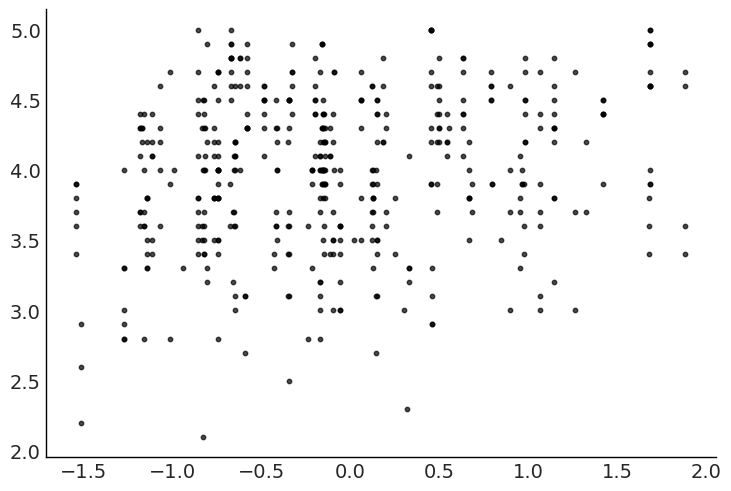

In [4]:
fig, ax = plt.subplots()
ax.scatter("beauty", "eval", data=beauty, color="black", s=10, alpha=0.7);

### Fit a linear regression

In [5]:
model_1 = bmb.Model("eval ~ beauty", data=beauty)
idata_1 = model_1.fit()
az.summary(idata_1, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eval_sigma, Intercept, beauty]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,4.010,0.026,3.964,4.060
beauty,0.133,0.032,0.070,0.189
eval_sigma,0.547,0.019,0.514,0.584


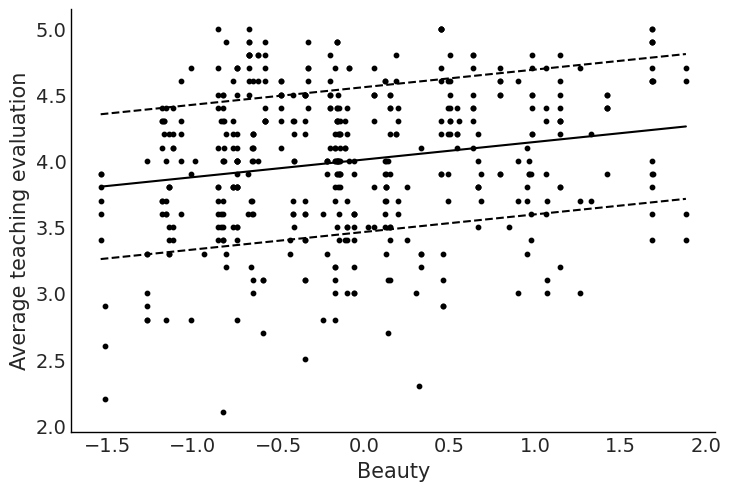

In [6]:
stats_1 = az.summary(idata_1, kind="stats")["mean"]
x = np.linspace(beauty["beauty"].min(), beauty["beauty"].max(), 10)
y_pred = stats_1["Intercept"] + stats_1["beauty"] * x

fig, ax = plt.subplots()
ax.scatter("beauty", "eval", data=beauty, color="black", s=10)
ax.set_xlabel("Beauty")
ax.set_ylabel("Average teaching evaluation")
ax.plot(x, y_pred, color="black")
ax.plot(x, y_pred + stats_1["eval_sigma"], color="black", linestyle="--")
ax.plot(x, y_pred - stats_1["eval_sigma"], color="black", linestyle="--");

## Do things differ for male and female profs?
### Parallel regression lines

In [8]:
model_2 = bmb.Model("eval ~ beauty + female", data=beauty)
idata_2 = model_2.fit()
az.summary(idata_2, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eval_sigma, Intercept, female, beauty]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,4.094,0.033,4.032,4.154
beauty,0.148,0.032,0.087,0.209
female,-0.198,0.052,-0.295,-0.104
eval_sigma,0.538,0.018,0.506,0.573


### Make two subplots

/var/folders/q1/wt8mfyzs73l2r5977rk_mkxm0000gn/T/ipykernel_30151/4287179046.py:31: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout();


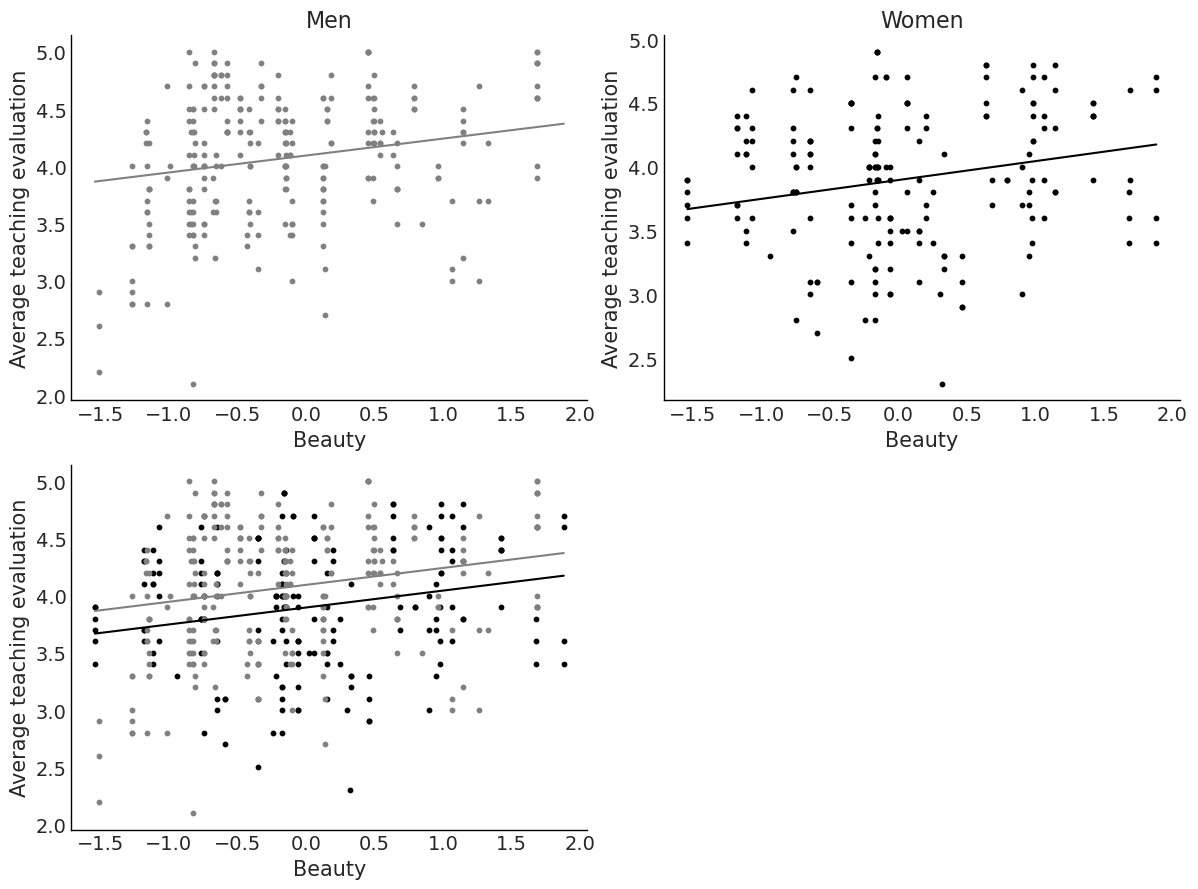

In [9]:
stats_2 = az.summary(idata_2, kind="stats")["mean"]
x = np.linspace(beauty["beauty"].min(), beauty["beauty"].max(), 10)
y_pred_male = stats_2["Intercept"] + stats_2["beauty"] * x
y_pred_female = stats_2["Intercept"] + stats_2["female"] + stats_2["beauty"] * x

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 9))

# Men
ax1.scatter("beauty", "eval", data=beauty.query("female == 0"), color="grey", s=10)
ax1.set_title("Men")
ax1.set_xlabel("Beauty")
ax1.set_ylabel("Average teaching evaluation")
ax1.plot(x, y_pred_male, color="grey")

# Women
ax2.scatter("beauty", "eval", data=beauty.query("female == 1"), color="black", s=10)
ax2.set_title("Women")
ax2.set_xlabel("Beauty")
ax2.set_ylabel("Average teaching evaluation")
ax2.plot(x, y_pred_female, color="black")

# Both sexes
ax3.scatter("beauty", "eval", data=beauty.query("female == 1"), color="black", s=10)
ax3.scatter("beauty", "eval", data=beauty.query("female == 0"), color="grey", s=10)
ax3.set_xlabel("Beauty")
ax3.set_ylabel("Average teaching evaluation")
ax3.plot(x, y_pred_female, color="black")
ax3.plot(x, y_pred_male, color="grey")

ax4.remove()
plt.tight_layout();

## Do things differ for male and female profs?
### Non-parallel regression lines

In [10]:
model_3 = bmb.Model("eval ~ beauty + female + beauty*female", data=beauty)
idata_3 = model_3.fit()
az.summary(idata_3, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eval_sigma, Intercept, beauty:female, female, beauty]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,4.104,0.033,4.041,4.165
beauty,0.200,0.043,0.124,0.284
female,-0.205,0.052,-0.303,-0.108
beauty:female,-0.113,0.063,-0.231,0.002
eval_sigma,0.537,0.017,0.502,0.568


/var/folders/q1/wt8mfyzs73l2r5977rk_mkxm0000gn/T/ipykernel_30151/3950564368.py:29: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout();


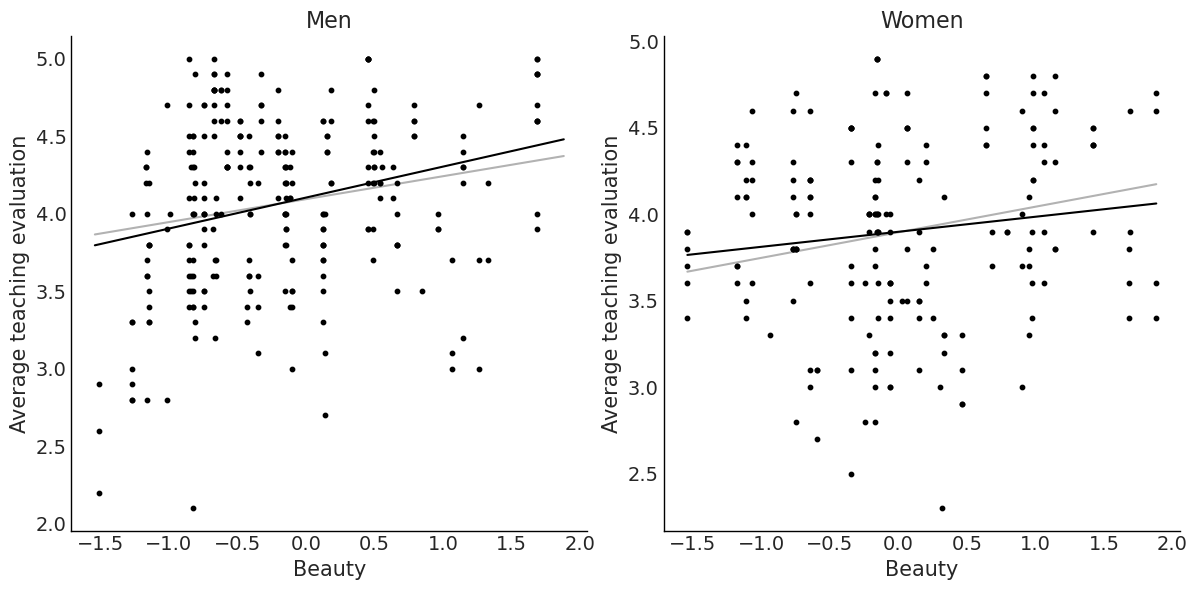

In [11]:
stats_3 = az.summary(idata_3, kind="stats")["mean"]
x = np.linspace(beauty["beauty"].min(), beauty["beauty"].max(), 10)
y_pred_male_interaction = stats_3["Intercept"] + stats_3["beauty"] * x
y_pred_female_interaction = (
    stats_3["Intercept"]
    + stats_3["female"] * 1
    + stats_3["beauty"] * x
    + stats_3["beauty:female"] * x * 1
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Men
ax1.scatter("beauty", "eval", data=beauty.query("female == 0"), color="black", s=10)
ax1.set_title("Men")
ax1.set_xlabel("Beauty")
ax1.set_ylabel("Average teaching evaluation")
ax1.plot(x, y_pred_male, color="black", alpha=0.3)
ax1.plot(x, y_pred_male_interaction, color="black")

# Women
ax2.scatter("beauty", "eval", data=beauty.query("female == 1"), color="black", s=10)
ax2.set_title("Women")
ax2.set_xlabel("Beauty")
ax2.set_ylabel("Average teaching evaluation")
ax2.plot(x, y_pred_female, color="black", alpha=0.3)
ax2.plot(x, y_pred_female_interaction, color="black")

plt.tight_layout();

## More models
### Add age

In [12]:
model_4 = bmb.Model("eval ~ beauty + female + age", data=beauty)
idata_4 = model_4.fit()
az.summary(idata_4, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eval_sigma, Intercept, age, female, beauty]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,4.223,0.143,3.965,4.503
beauty,0.140,0.034,0.078,0.205
female,-0.210,0.053,-0.308,-0.112
age,-0.003,0.003,-0.008,0.003
eval_sigma,0.539,0.018,0.504,0.572


### Add minority

In [13]:
model_5 = bmb.Model("eval ~ beauty + female + minority", data=beauty)
idata_5 = model_5.fit()
az.summary(idata_5, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eval_sigma, Intercept, minority, female, beauty]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,4.105,0.035,4.038,4.168
beauty,0.150,0.033,0.088,0.210
female,-0.189,0.053,-0.287,-0.093
minority,-0.103,0.073,-0.239,0.032
eval_sigma,0.538,0.018,0.505,0.573


### Add nonenglish

In [14]:
model_6 = bmb.Model("eval ~ beauty + female + nonenglish", data=beauty)
idata_6 = model_6.fit()
az.summary(idata_6, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eval_sigma, Intercept, nonenglish, female, beauty]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,4.115,0.034,4.051,4.179
beauty,0.150,0.032,0.092,0.213
female,-0.198,0.052,-0.296,-0.102
nonenglish,-0.334,0.103,-0.537,-0.151
eval_sigma,0.533,0.018,0.501,0.569


### Add nonenglish and lower

In [15]:
model_7 = bmb.Model("eval ~ beauty + female + nonenglish + lower", data=beauty)
idata_7 = model_7.fit()
az.summary(idata_7, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eval_sigma, Intercept, lower, nonenglish, female, beauty]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,4.078,0.039,4.005,4.152
beauty,0.147,0.032,0.089,0.210
female,-0.191,0.052,-0.290,-0.097
nonenglish,-0.307,0.105,-0.488,-0.102
lower,0.094,0.053,-0.003,0.192
eval_sigma,0.532,0.018,0.500,0.565


In [16]:
## Simple model with course indicators
### Include course indicators in a regression

In [17]:
model_8 = bmb.Model("eval ~ beauty + C(course_id)", data=beauty)
idata_8 = model_8.fit()
az.summary(idata_8, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eval_sigma, Intercept, C(course_id), beauty]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,4.031,0.031,3.974,4.091
beauty,0.136,0.033,0.074,0.200
C(course_id)[1],0.364,0.239,-0.071,0.821
C(course_id)[2],0.419,0.369,-0.268,1.106
C(course_id)[3],-0.175,0.189,-0.527,0.186
C(course_id)[4],-0.201,0.122,-0.436,0.021
C(course_id)[5],0.017,0.254,-0.471,0.467
C(course_id)[6],-0.126,0.211,-0.546,0.253
C(course_id)[7],-0.325,0.272,-0.819,0.212
C(course_id)[8],-0.143,0.378,-0.848,0.568
